## Flower classification

There are 210 images (128x128x3) with 10 species/classes of flowers in this dataset. The objective is to classify flowers into different classes namely: 

0 => phlox;

1 => rose;

2 => calendula;

3 => iris;

4 => leucanthemum maximum (Shasta daisy);

5 => campanula (bellflower);

6 => viola;

7 => rudbeckia laciniata (Goldquelle);

8 => peony;

9 => aquilegia.

**The dataset can be downloaded from : https://www.kaggle.com/olgabelitskaya/flower-color-images**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam 
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator


from keras.applications import *
from keras.applications.vgg19 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

In [2]:
ROOT = '../input/flower-color-images/flower_images/flower_images/'

df = pd.read_csv(ROOT + 'flower_labels.csv')

In [3]:
df = df.replace({0:'phlox',1:'rose',2:'calendula',3:'iris',4:'leucanthemum maximum',
                 5:'bellflower',6:'viola',7:'rudbeckia laciniata',
                 8:'peony',9:'aquilegia'})

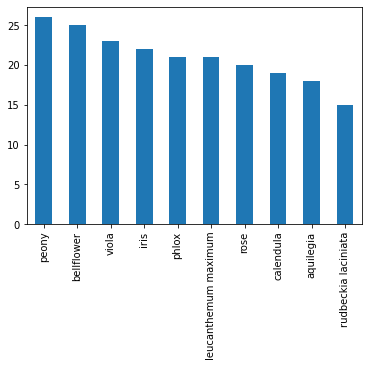

In [4]:
df.label.value_counts().plot.bar()

## Plot random images of flowers

Plot random images of flowers


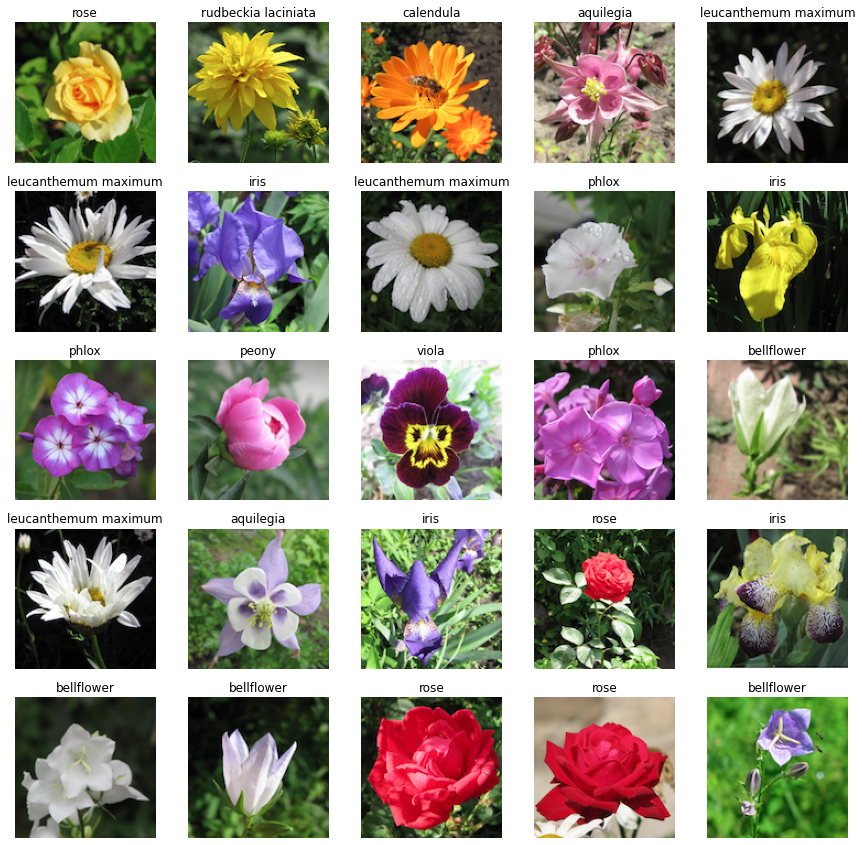

In [5]:
def img_plot(df):
    print("Plot random images of flowers")
    imgs = []
    labels = []
    df = df.sample(frac=1)
    for file, label in zip(df['file'][:25], df['label'][:25]):
        img = cv2.imread(ROOT+file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
        labels.append(label)
    f, ax = plt.subplots(5, 5, figsize=(15,15))
    for i, img in enumerate(imgs):
        ax[i//5, i%5].imshow(img)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title(labels[i])
    plt.show()

img_plot(df)

In [6]:
num_classes = len(df.label.value_counts())
num_classes

10

In [7]:
train_input_shape = (299,299, 3)
IMG_SIZE = 299
SEED = 42
batch_size = 32
train_df, test_df = train_test_split(df, 
                                     test_size=0.2, 
                                     random_state=SEED, 
                                     stratify=df['label'].values)

In [8]:
def create_datasets(df, img_size):
    imgs = []
    for file in tqdm(df['file']):
        img = cv2.imread(ROOT+file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size,img_size))
        imgs.append(img)
    # not normalize    
    imgs = np.array(imgs)
    df = pd.get_dummies(df['label'])
    return imgs, df


train_imgs, train_df = create_datasets(train_df, IMG_SIZE)
test_imgs, test_df = create_datasets(test_df, IMG_SIZE)

100%|██████████| 42/42 [00:00<00:00, 78.54it/s]


In [10]:
xception = Xception(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in xception.layers:
    layer.trainable = True


83689472/83683744 [==============================] - 1s 0us/step


In [11]:
xception.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [12]:
# our layers - you can add more if you want
x = xception.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(10, activation='softmax')(x) # 10 since we have only 10 categories

In [13]:
model = Model(xception.input, predictions)

In [14]:
# view the structure of the model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [15]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

In [17]:
r = model.fit(train_imgs, train_df, batch_size=32,validation_data = (test_imgs, test_df),
          epochs=20, verbose=0)

Text(0.5, 1.0, 'Accuracy')

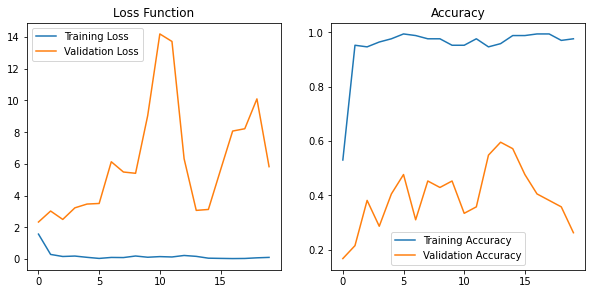

In [18]:
#Plot train and test loss and Accuracy
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Training Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Function')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Training Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

In [19]:
!mkdir models
!mkdir models/keras

In [20]:
model.save('models/keras/model.h5')

In [21]:
model = load_model('models/keras/model.h5')

In [22]:
# save
model.save_weights('models/keras/weights.h5')
with open('models/keras/architecture.json', 'w') as f:
        f.write(model.to_json())

In [ ]:
# load
with open('models/keras/architecture.json') as f:
    model = model_from_json(f.read())
model.load_weights('models/keras/weights.h5')